# BNP Fraudsters - Modeling

The previous EDA notebook detailed how different columns in this dataset are linked, in particular the hierarchical relationships between our categorical columns `item, make` < `model` < `goods_code` < `ID`.

We also noticed that most categorical columns showed morphological similarities and typos, which increases the cardinality of each column significantly. When not propertly encoded, high cardinality columns usually have few samples for each category, degrading the predictive performance of the estimator.

We also established that each row in this dataset conceptually represents a basket, which is a list of products of variable length. The dataframe representation flattens these lists by fixing the number of products to 24, which creates a sparse dataframe.

The order of products in the list might also bring predictive power, at the cost of reducing the vocabulary for each categorical column.

Finally, as we are tackling a fraudulent loans detection use-case, the dataset is extremely imbalanced, with a prevalence around 1.4%. We will try to derive a cost function based on few questionable assumptions about the use-case. To improve this function, it is mandatory to get more insights from a domain expert at BNP Paribas and contextualise the working environment of the model and how its predictions will be used.

## 1. Setup

We start with loading the features and showing the attributes of the first product in each basket.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from mandr.examples.fraud.eda_plots import get_group_cols


X = pd.read_csv("X_train.csv", low_memory=False)
X.pop("ID")

renaming = dict(
    zip(
        get_group_cols("Nbr_of_prod_purchas"),
        get_group_cols("nbr"),
    )
)
X = X.rename(columns=renaming)

attribute_cols = ["item", "cash_price", "make", "model", "goods_code", "nbr"]
first_cols = [*[f"{col}1" for col in attribute_cols], "Nb_of_items"]
X[first_cols]

,item1,cash_price1,make1,model1,goods_code1,nbr1,Nb_of_items
0,COMPUTERS,889.0,APPLE,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,239246776,1.0,1.0
1,COMPUTER PERIPHERALS ACCESSORIES,409.0,APPLE,APPLE WATCH SERIES 6 GPS 44MM SPACE GREY ALUMI...,239001518,1.0,1.0
2,TELEVISIONS HOME CINEMA,1399.0,SAMSUNG,SAMSUNG QE75Q70A 2021 QLED HDR 4K ULTRA HD SMA...,239842093,1.0,1.0
3,COMPUTERS,689.0,APPLE,2020 APPLE IPAD AIR 10 9 A14 BIONIC PROCESSOR IOS,239001422,1.0,2.0
4,TELEVISIONS HOME CINEMA,1199.0,SONY,SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD S...,239952954,1.0,1.0
...,...,...,...,...,...,...,...
92785,COMPUTER PERIPHERALS ACCESSORIES,299.0,SAMSUNG,SAMSUNG GALAXY WATCH 3 BLUETOOTH 41MM STAINLES...,238905679,1.0,2.0
92786,COMPUTERS,898.0,APPLE,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,239246776,1.0,1.0
92787,BEDROOM FURNITURE,519.0,SILENTNIGHT,SILENTNIGHT END DIVAN OTTOMAN STORAGE BED DOUBLE,236938427,1.0,3.0
92788,COMPUTERS,1099.0,APPLE,2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-F...,240040978,1.0,2.0


Note that the full dataframe contains 24 times these columns:

In [2]:
X.shape

(92790, 145)

We load the target and apply a stratified shuffle split to get a training, validation and testing dataset, with ratios 81% / 9% / 10%. In this notebook, the validation set will be used for post-training tuning of the classification threshold. This could also be used for e.g. calibrating trained estimators.

Note that for computation cost reasons, **we don't use an outer cross validation loop here**. This would consist in iterating over various random seeds during the split operation, and estimating the performance across these different splits. This would give us a stronger estimate of our models performance and confidence intervals.

In [3]:
y = pd.read_csv("Y_train.csv", index_col="index")["fraud_flag"]
y

index
0        0
1        0
2        0
3        0
4        0
        ..
92785    0
92786    0
92787    0
92788    0
92789    0
Name: fraud_flag, Length: 92790, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.1, stratify=y, random_state=0,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.1, stratify=y_train, random_state=0,
)
X_train.shape, X_val.shape, X_test.shape

((75159, 145), (8352, 145), (9279, 145))

We need to define scoring metrics to estimate the performance of our models.
- Our first reflex should always be to **create a utility metric with a tangible unit**. In our case, it could be the gains yielded by our model in euros, defined by a cost matrix.
- It's also useful to check **proper scoring rules** on the predicted probabilities, like the log loss and the brier score. In general terms, we should avoid optimizing thresholded metrics like accuracy or f1-score during training, as the default threshold of 0.5 is often not adapted to our problem from a utility point of view.

We define our cost matrix using the total price of the basket. Our assumptions are:
- A **true positive** prediction yields 0€. We identified a fraudulent loan and rejected it. No harm done.
- A **true negative** prediction yields 7% of the total price. This corresponds to a premium applied by the creditor on the loan amount, on a non fraudulent transaction.
- A **false positive** prediction yields a fix gain of -5€. This is the price of a false alarm, maybe in reputation or using resources to run a KYC an finally having a agent deciding whether to accept the loan or not.
- A **false negative** is the more costly error, since the fraudster gets away with the total price of the basket. This corresponds to a net loss of the total price.

We define the total basket price as the sum of the products unitary prices, multiplied by their respective quantities.

In [5]:
MAX_ITEMS = 24

def total_price(X):

    total_price = pd.Series(
        np.zeros(X.shape[0]), index=X.index, name="total_price"
    )
    
    for idx in range(1, MAX_ITEMS+1):
        total_price += (
            X[f"cash_price{idx}"].fillna(0)
            * X[f"nbr{idx}"].fillna(0)
        )
        
    return total_price

We compute the total price over the three datasets. Note that we could have also computed this quantity before splitting.

In [6]:
for X_ in [X_train, X_val, X_test]:
    X_["total_price"] = total_price(X_)

We use the `make_scorer` function to turn a metric into a score that can be used by a cross validation object in scikit-learn. For proper scoring rules, lower is better, and we need to use predicted classes probabilities instead of predicted classes.

We also need to activate metadata routing to compute the cost gain, since we need to pass the `total_price` column to the score function.

In [7]:
import sklearn
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    log_loss,
    brier_score_loss,
    confusion_matrix,
    average_precision_score,
)


def fpr_score(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tn, fp, _, _ = cm.ravel()
    return fp / (tn + fp)


def credit_gain_score(y_true, y_pred, amount):
    
    mask_tp = (y_true == 1) & (y_pred == 1)
    mask_tn = (y_true == 0) & (y_pred == 0)
    mask_fp = (y_true == 0) & (y_pred == 1)
    mask_fn = (y_true == 1) & (y_pred == 0)
    
    fraudulent_refuse = 0
    fraudulent_accept = -amount[mask_fn].sum()
    legitimate_refuse = mask_fp.sum() * -5
    legitimate_accept = (amount[mask_tn] * 0.07).sum()
    
    return fraudulent_refuse + fraudulent_accept + legitimate_refuse + legitimate_accept


# Our target is to predict whether or not a credit is bad.
tpr_score = recall_score  # TPR and recall are the same metric
sklearn.set_config(enable_metadata_routing=True)
scoring = {
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "fpr": make_scorer(fpr_score),
    "tpr": make_scorer(tpr_score),
    "log_loss": make_scorer(
        log_loss,
        greater_is_better=False,
        response_method="predict_proba"
    ),
    "brier_score_loss": make_scorer(
        brier_score_loss,
        greater_is_better=False,
        response_method="predict_proba"
    ),
    "cost_gain": make_scorer(credit_gain_score).set_score_request(amount=True),
    "average_precision_score": make_scorer(average_precision_score),
}

results = dict()

We write a simple utility function to make a result dictionary for each model, containing the predicted probabilities, and all the score we defined above.

In [8]:
def get_results(model, X_test, y_test, amount, threshold):
    results_ = {
        "y_proba": model.predict_proba(X_test),
        "y_test": y_test,
        "model": model,
        "threshold": threshold,
        "params": model.get_params(),
    }
    for scoring_name, scoring_func in scoring.items():
        if scoring_name == "cost_gain":
            results_[scoring_name] = scoring_func(
                model, X_test, y_test, amount=amount
            )
        else:
            score = scoring_func(model, X_test, y_test)
            if scoring_name in ["brier_score_loss", "log_loss"]:
                score *= -1 
            results_[scoring_name] = score

    return results_

The setup is now done. Let's start evaluating models!

## 2. Dummy baselines and oracle

On one hand, we have to score **dummy baselines**. Dummies are by definition the lowest effort possible. It would be concerning to not beat them. We use two distinct strategies:
1. Randomly predict the target using the prevalence i.e. predicting 1 only 1.4% of the time (`stratified`)
2. Always return 1 (`constant`).

On the other hand, we also create **an oracle**, i.e. a classifier with perfect predictions. It is generally impossible to attain due to the non explainable variance in the target. The oracle classifier simply saves the target of the test set and returns it.

These two type of models form the expected lower and upper bounds of our performance.

In [9]:
from sklearn.dummy import DummyClassifier
from mandr.examples.fraud.oracle import OracleClassifier


dummy_random = DummyClassifier(
    strategy="stratified"
).fit(X_train, y_train)

dummy_negative = DummyClassifier(
    strategy="constant", constant=0
).fit(X_train, y_train)

oracle = OracleClassifier().fit(None, y_test)

results["stratified_random"] = get_results(
    dummy_random, X_test, y_test, amount=X_test["total_price"], threshold=.5
)
results["always_negative"] = get_results(
    dummy_negative, X_test, y_test, amount=X_test["total_price"], threshold=.5
)
results["oracle"] = get_results(
    oracle, X_test, y_test, amount=X_test["total_price"], threshold=.5
)

/Users/vincentmaladiere/miniforge3/envs/mandr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3. Low effort estimator

Once these baselines are in place, we can start proper modeling. The first idea that comes to mind is to limit our feature engineering to a simple encoding of our categories with a HistGradientBoostingClassifier. This is our low effort estimator.

As the cardinality of most categorical columns is higher than the number of bins created by the boosting tree (255), we have some few encoding options:

- **Reducing the categories to the top 254 most frequent**, with an extra categories for the NaN and the unseen during predict. We can do so with an OrdinalEncoder, but we would loose some of the rare categories in an "other" bin.
- **Encoding the categories as float**. This can be done efficiently with the TargetEncoder and is our favourite option.

The TargetEncoder also creates some sort of similarity between different categories that have the same target frequency, whereas the OrdinalEncoder considers all categories as orthogonal.

Note that we would prefer OrdinalEncoder to OneHotEncoder because:
1. Creating one column per categories with a OneHotEncoder is impracticable with this dataset and the dimensionality would explode.
2. Boosting tree are natively able to handle categories, and unlike linear models, the ordering of the OrdinalEncoder doesn't affect tree-based models. Plus, creating additional columns with a OneHotEncoder usually diminishes the inductive biases of the trees.

Last but not least, boosting tree models natively handles missing values, so we don't even need to impute them.

We use the **TableVectorizer** from skrub which automatically selects the categorical columns (string, object or categorical dtypes in pandas) and apply the TargetEncoder on them. We don't transform numeric columns.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer


vectorizer = TableVectorizer(
    high_cardinality=TargetEncoder(),
    cardinality_threshold=1,
)
vectorizer

TableVectorizer(cardinality_threshold=1, high_cardinality=TargetEncoder())

After defining our vectorizer, our next aim is to fine tune the hyper-parameters of our boosting tree. Since fitting the vectorizer takes approximately 10s and making prediction 1s, we don't chain the vectorizer and the boosting tree together in a pipeline to limit redundant computations during cross validation.

Note that we don't use the memory argument of the pipeline to save even more time by precomputing the vectorized dataset only once.

In [11]:
X_trans_train = vectorizer.fit_transform(X_train, y_train)
X_trans_val = vectorizer.transform(X_val)
X_trans_test = vectorizer.transform(X_test)
X_trans_train

,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,...,nbr17,nbr18,nbr19,nbr20,nbr21,nbr22,nbr23,nbr24,Nb_of_items,total_price
67930,0.022303,0.002615,0.004144,0.006009,0.014313,0.014223,0.014201,0.014171,0.014192,0.014159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1547.0
82728,0.003042,0.012357,0.015103,0.014573,0.014273,0.014196,0.014201,0.014199,0.014208,0.014161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,399.0
66599,0.031726,0.025134,0.015166,0.014579,0.014313,0.014202,0.014269,0.014199,0.014162,0.014142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1606.0
84151,0.000000,0.026409,0.000000,0.014634,0.014273,0.014256,0.014269,0.014171,0.014141,0.014142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1009.0
55349,0.022180,0.012726,0.015202,0.014634,0.014364,0.014202,0.014235,0.014171,0.014208,0.014161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78800,0.022364,0.067277,0.000000,0.014573,0.014247,0.014206,0.014269,0.014195,0.014141,0.014146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,946.0
44433,0.003181,0.012944,0.015202,0.014579,0.014364,0.014196,0.014201,0.014195,0.014141,0.014161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,369.0
58689,0.022364,0.025134,0.015103,0.014573,0.014345,0.014223,0.014217,0.014199,0.014192,0.014161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,539.0
12559,0.022364,0.025631,0.014997,0.014634,0.014273,0.014202,0.014201,0.014216,0.014208,0.014161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,938.0


We use a RandomizedSearchCV to find the best hyper-parameters combination, over a small quantity of draws to stay computationally cheap (`n_iter=5`).

The model itself is trained on the log loss (the default), so **we evaluate it on the brier score** to avoid training and evaluating using the same metric. Doing otherwise can lead to over-optimistic estimation of the performance.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint


param_distributions = dict(
    learning_rate=loguniform(0.001, 0.5),
    max_depth=randint(2, 10),
    min_samples_leaf=randint(5, 50),
    max_iter=randint(100, 1000),
)

random_search_params = dict(
    param_distributions=param_distributions,
    n_iter=5,
    scoring=scoring["brier_score_loss"],
    refit=True,
    verbose=1,
    error_score="raise",
)

low_effort_hgbt = HistGradientBoostingClassifier()

hgbt_search = RandomizedSearchCV(
    low_effort_hgbt,
    **random_search_params,
).fit(X_trans_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


We then evaluate the performance on the test set using our helper function, and display the brier score and the cost gain.

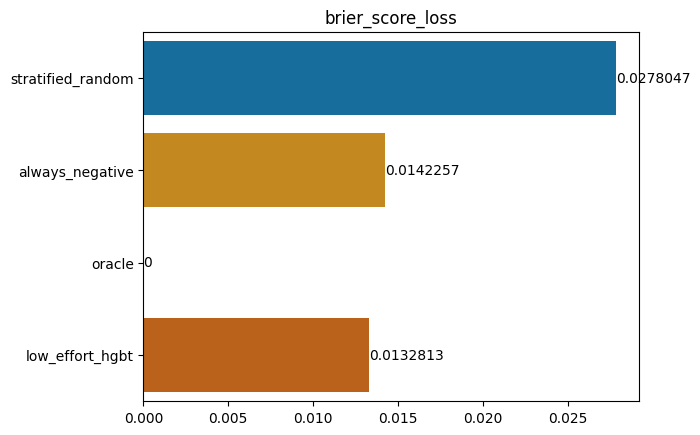

In [13]:
from mandr.examples.fraud.modeling_plots import plot_metric

results["low_effort_hgbt"] = get_results(
    hgbt_search.best_estimator_,
    X_trans_test,
    y_test,
    amount=X_test["total_price"],
    threshold=.5,
)

plot_metric(results, metric_name="brier_score_loss")

We beat the dummy baselines by a slight margin, and are quite far from the oracle at 0.

Let's compare this to the log loss.

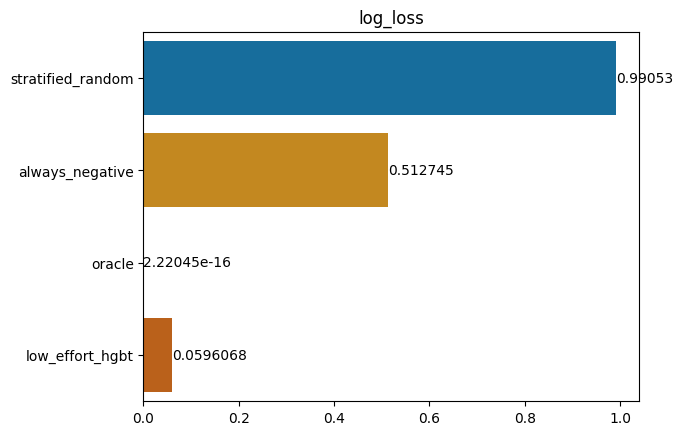

In [14]:
plot_metric(results, metric_name="log_loss")

Since the model has been trained on the log loss, it is significantly better than the dummies.

Next, we should look at our utility function. Is our model significantly better than the dummies on this metric too?

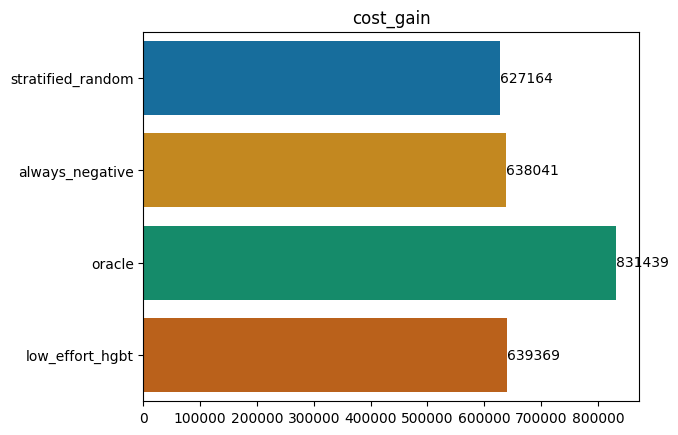

In [15]:
plot_metric(results, metric_name="cost_gain")

The gap between our model and the dummies for the utility function is tighter, like for the brier score. A model always accepting all transactions yields 638k€, while the best achievable gain of the oracle is around 831k€. Our model gain is 639€k. Error bars would be helpful here.

However, the gain has been evaluated with the default classification threshold of 0.5, so there is room for improvement by optimizing this threshold using the TunedThresholdClassifierCV. This time, **we set the scoring objective as the cost gain**.

To avoid running an expensive nested cross validation of the randomized search within the tuned threshold classifier, we reuse the previous best fitted model with `cv=prefit`. By doing so, **we must use the validation set instead of the training set** to avoid introducing an important bias.

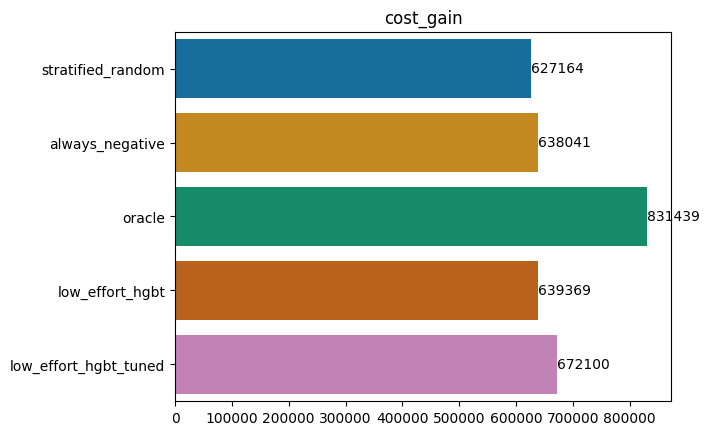

In [16]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_params = dict(
    scoring=scoring["cost_gain"],
    store_cv_results=True,
    cv="prefit",
    refit=False,
)

tuned_hgbt = TunedThresholdClassifierCV(
    hgbt_search.best_estimator_,
    **tuned_params,
).fit(
    X_trans_val,
    y_val,
    amount=X_val["total_price"],
)

results["low_effort_hgbt_tuned"] = get_results(
    tuned_hgbt,
    X_trans_test,
    y_test,
    amount=X_test["total_price"],
    threshold=tuned_hgbt.best_threshold_,
)

plot_metric(results, metric_name="cost_gain")

Our gain is now higher than 670k€, which is a nice and quite cheap improvement!

A good follow-up is to investigate which hyper-parameters are correlated with a low brier score and a high fitting time.

In [17]:
cv_results = pd.DataFrame(hgbt_search.cv_results_["params"])

for col in ["mean_test_score", "mean_fit_time"]:
    cv_results[col] = hgbt_search.cv_results_[col]

cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results

,learning_rate,max_depth,max_iter,min_samples_leaf,mean_test_score,mean_fit_time
2,0.004202,7,851,26,-0.012940,10.911412
0,0.060410,3,949,42,-0.012953,1.148171
1,0.336035,2,751,42,-0.013207,0.579913
4,0.107818,6,408,20,-0.013469,0.959693
3,0.142950,9,997,11,-0.016151,0.774993


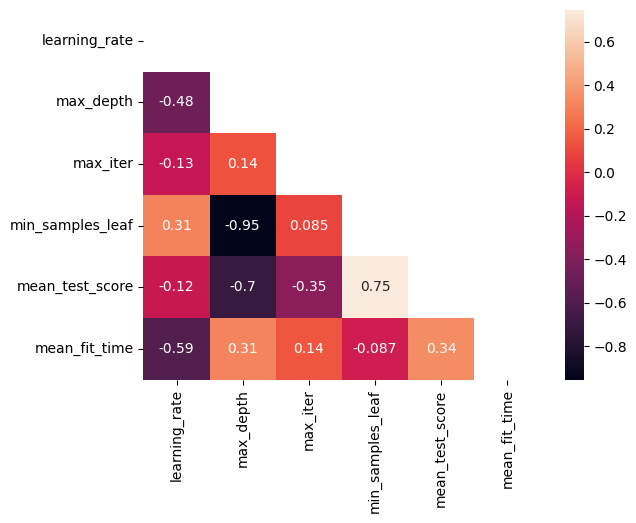

In [18]:
corr = cv_results.corr()
corr_triu = np.triu(corr)
sns.heatmap(corr, annot=True, mask=corr_triu);

Since we are considering the negative brier score, higher is better. **These correlations must be taken with a big grain of salt though** because the number of combination tested is  small (`n_iter=5`).

## 4. MinHash estimator

How could we improve upon the low effort estimator? We could first try to derive more features from each basket. Starting with the numeric columns, a simple idea is to compute basic statistics for the unitary price and the quantity of each product.

In [19]:
def row_aggregate_number(
    X,
    operations=("mean", "sum", "std", "min", "max")
):
    X_out = pd.DataFrame(index=X.index)
    
    for attribute_col in ["cash_price", "nbr"]:
        cols = get_group_cols(attribute_col)
        for operation in operations:
            X_col = (
                X[cols].apply(operation, axis=1)
                       .rename(f"{attribute_col}_{operation}")
                       .fillna(0)
            )
            X_out = pd.concat([X_out, X_col], axis=1)

    X_out["total_price"] = total_price(X)
    
    return X_out

Since this function is stateless (i.e. it doesn't require a fitting step), we can easily include it in a pipeline using a FunctionTransformer. It takes a dataframe as input and output the transformation.

In [20]:
from sklearn.preprocessing import FunctionTransformer


row_aggregate_number_transformer = FunctionTransformer(row_aggregate_number)
row_aggregate_number_transformer.fit_transform(X_train, y_train)

,cash_price_mean,cash_price_sum,cash_price_std,cash_price_min,cash_price_max,nbr_mean,nbr_sum,nbr_std,nbr_min,nbr_max,total_price
67930,386.750000,1547.0,451.686008,80.0,1049.0,1.0,4.0,0.0,1.0,1.0,1547.0
82728,399.000000,399.0,0.000000,399.0,399.0,1.0,1.0,0.0,1.0,1.0,399.0
66599,803.000000,1606.0,1125.713996,7.0,1599.0,1.0,2.0,0.0,1.0,1.0,1606.0
84151,336.333333,1009.0,530.961706,10.0,949.0,1.0,3.0,0.0,1.0,1.0,1009.0
55349,569.000000,569.0,0.000000,569.0,569.0,1.0,1.0,0.0,1.0,1.0,569.0
...,...,...,...,...,...,...,...,...,...,...,...
78800,315.333333,946.0,359.808745,75.0,729.0,1.0,3.0,0.0,1.0,1.0,946.0
44433,369.000000,369.0,0.000000,369.0,369.0,1.0,1.0,0.0,1.0,1.0,369.0
58689,269.500000,539.0,381.130555,0.0,539.0,1.0,2.0,0.0,1.0,1.0,539.0
12559,469.000000,938.0,663.266161,0.0,938.0,1.0,2.0,0.0,1.0,1.0,938.0


Next, let's take a closer look at the categories. We saw in the EDA notebook that there were typos and similarities, so we need an encoder able to handle morphological variations. Here, we can use both MinHashEncoder and GapEncoder from skrub. The former is a stateless transformer, fast to compute and whose embeddings are efficient for learning with tree based models.

However, with 3 * 24 categorical columns to encode and embeddings of size 30 by default, our total output dimension would be 3 * 24 * 30 = 2160 dimensions, which would be very expensive to store in RAM.

So we need row-wise aggregation of our embeddings. But how to aggregate these? MinHash embeddings are not comparable in an Euclidean space, but they encode minimum of some hash values, so we can take **the minimum value** for each dimension across all 24 products, for each group (`item`, `make`, and `model`).

For each basket, this yields an embedding vector of size 3 * 30.

In [21]:
from skrub import MinHashEncoder


def row_aggregate_minhash(
    X,
    attribute_cols=("item", "make", "model"),
    encoder=None,
):
    if encoder is None:
        encoder = MinHashEncoder()
    
    X_out = pd.DataFrame(index=X.index)
        
    for attribute_col in attribute_cols:
        group_cols = get_group_cols(attribute_col)
        
        X_trans = TableVectorizer(
            high_cardinality=encoder,
            cardinality_threshold=1, # no low cardinality
        ).fit_transform(X[group_cols], y)
        
        n_samples, n_columns = X_trans.shape[0], len(group_cols)
        X_trans = (
            X_trans.to_numpy()
                .reshape(n_samples, n_columns, -1)  # (n_samples, 24, 30)
                .min(axis=1) # take minimum across the basket, for each embedding dimension.
        )
        columns = [f"{attribute_col}_e{idx}" for idx in range(X_trans.shape[1])]
        X_trans = pd.DataFrame(
            X_trans,
            columns=columns,
            index=X.index,
        )
        X_out = pd.concat([X_out, X_trans], axis=1)

    return X_out

In [22]:
row_aggregate_minhash_transformer = FunctionTransformer(row_aggregate_minhash)
row_aggregate_minhash_transformer.fit_transform(X_train, y_train)

,item_e0,item_e1,item_e2,item_e3,item_e4,item_e5,item_e6,item_e7,item_e8,item_e9,...,model_e20,model_e21,model_e22,model_e23,model_e24,model_e25,model_e26,model_e27,model_e28,model_e29
67930,-2.119082e+09,-2.092438e+09,-2.091895e+09,-2.096070e+09,-2.053898e+09,-2.069353e+09,-2.075300e+09,-2.009485e+09,-2.071984e+09,-2.089786e+09,...,-2.137696e+09,-2.143422e+09,-2.095641e+09,-2.146054e+09,-2.135835e+09,-2.133460e+09,-2.132541e+09,-2.141458e+09,-2.143995e+09,-2.138675e+09
82728,-2.119082e+09,-2.092438e+09,-2.091895e+09,-2.096070e+09,-2.053898e+09,-2.069353e+09,-2.075300e+09,-2.009485e+09,-2.071984e+09,-2.089786e+09,...,-2.140468e+09,-2.117243e+09,-2.077026e+09,-2.087341e+09,-2.065861e+09,-2.100476e+09,-2.120272e+09,-2.114560e+09,-2.119326e+09,-1.987577e+09
66599,-2.119082e+09,-2.124355e+09,-2.143066e+09,-2.121657e+09,-2.045774e+09,-2.097416e+09,-2.121149e+09,-2.063175e+09,-2.142877e+09,-2.114542e+09,...,-1.893209e+09,-2.112149e+09,-2.079610e+09,-1.981345e+09,-1.987062e+09,-1.920174e+09,-2.106766e+09,-2.092953e+09,-2.103723e+09,-2.132384e+09
84151,-1.986420e+09,-1.995913e+09,-2.091895e+09,-2.070602e+09,-1.967898e+09,-2.032195e+09,-2.075300e+09,-1.820827e+09,-2.071984e+09,-2.053253e+09,...,-2.114070e+09,-2.096908e+09,-2.134135e+09,-2.121537e+09,-2.136538e+09,-2.106337e+09,-2.136946e+09,-2.134590e+09,-2.125134e+09,-2.082940e+09
55349,-2.119082e+09,-1.621485e+09,-1.795711e+09,-2.069713e+09,-2.053898e+09,-2.061027e+09,-1.407719e+09,-2.003758e+09,-1.860202e+09,-2.064848e+09,...,-2.130457e+09,-2.143422e+09,-2.056534e+09,-1.997467e+09,-2.135835e+09,-2.100476e+09,-2.082656e+09,-2.123857e+09,-2.139479e+09,-1.846253e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78800,-2.119082e+09,-2.140802e+09,-2.091895e+09,-2.134830e+09,-2.053898e+09,-2.100804e+09,-2.084104e+09,-2.136843e+09,-2.112901e+09,-2.064848e+09,...,-2.137696e+09,-2.143422e+09,-2.140851e+09,-2.124372e+09,-2.135835e+09,-2.128225e+09,-2.136662e+09,-2.123857e+09,-2.144493e+09,-2.146402e+09
44433,-2.119082e+09,-2.092438e+09,-2.091895e+09,-2.096070e+09,-2.053898e+09,-2.069353e+09,-2.075300e+09,-2.009485e+09,-2.071984e+09,-2.089786e+09,...,-2.114070e+09,-2.117243e+09,-2.077026e+09,-2.087341e+09,-2.065861e+09,-2.100476e+09,-2.120272e+09,-2.114560e+09,-2.092957e+09,-1.987577e+09
58689,-2.119082e+09,-2.063949e+09,-2.143066e+09,-2.121657e+09,-2.053898e+09,-2.085765e+09,-1.994253e+09,-2.003758e+09,-2.019966e+09,-2.064848e+09,...,-2.098945e+09,-2.087511e+09,-2.014152e+09,-2.042094e+09,-2.135835e+09,-2.100476e+09,-2.088567e+09,-2.092953e+09,-2.139479e+09,-1.933019e+09
12559,-2.119082e+09,-2.063949e+09,-2.143066e+09,-2.121657e+09,-2.053898e+09,-2.085765e+09,-1.994253e+09,-2.003758e+09,-2.019966e+09,-2.064848e+09,...,-2.137696e+09,-2.087511e+09,-2.021213e+09,-2.146054e+09,-2.135835e+09,-2.100476e+09,-2.088567e+09,-2.092953e+09,-2.103723e+09,-1.958826e+09


`goods_code` however is an ID with no morphological variations, so we don't expect MinHash to be efficient here. Instead, we encode each `goods_code` column with a target encoder, and then compute a row-wise weighted average, using the quantity `nbr` as weight.

This yields a single column.

In [23]:
def row_aggregate_post_target_encoder(X):
    goods_code_cols = get_group_cols("goods_code")
    nbr_cols = get_group_cols("nbr")
    avg_encoding = np.average(
        X[goods_code_cols],
        weights=X[nbr_cols].fillna(0),
        axis=1,
    )
    return pd.Series(
        avg_encoding, index=X.index, name="goods_code"
    ).to_frame()

In [24]:
from sklearn.compose import ColumnTransformer


target_encoder = ColumnTransformer(
    [
        ("target_encoder", TargetEncoder(), get_group_cols("goods_code")),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    force_int_remainder_cols=False,
)
target_encoder.set_output(transform="pandas")

row_aggregate = FunctionTransformer(row_aggregate_post_target_encoder)

row_aggregate_target_encoder = Pipeline([
    ("target_encoder", target_encoder),
    ("row_aggregate", row_aggregate),
])
row_aggregate_target_encoder

Pipeline(steps=[('target_encoder',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(),
                                                  ['goods_code1', 'goods_code2',
                                                   'goods_code3', 'goods_code4',
                                                   'goods_code5', 'goods_code6',
                                                   'goods_code7', 'goods_code8',
                                                   'goods_code9',
                                                   'goods_code10',
                                                   'goods_code11',
                                                   'goods_code12',
                                                   'goods_code13',
                                                   'goods_code14',
                                                   'goods_code15',
                                                   'goods_code16',
                                                   'goods_code17',
                                                   'goods_code18',
                                                   'goods_code19',
                                                   'goods_code20',
                                                   'goods_code21',
                                                   'goods_code22',
                                                   'goods_code23',
                                                   'goods_code24'])],
                                   verbose_feature_names_out=False)),
                ('row_aggregate',
                 FunctionTransformer(func=<function row_aggregate_post_target_encoder at 0x29fa6cfe0>))])

In [25]:
row_aggregate_target_encoder.fit_transform(X_train, y_train)

,goods_code
67930,0.011261
82728,0.005163
66599,0.012686
84151,0.009480
55349,0.025074
...,...
78800,0.015789
44433,0.001381
58689,0.014764
12559,0.018578


Finally, we can assemble our aggregation vectorizer by unioning all of our transformers. This will act as a horizontal concatenation of all transformers outputs.

In [26]:
from sklearn.pipeline import FeatureUnion


vectorizer = FeatureUnion([
    ("agg_number", row_aggregate_number_transformer),
    ("agg_category", row_aggregate_minhash_transformer),
    ("agg_goods_code", row_aggregate_target_encoder),
]).set_output(transform="pandas")

vectorizer

FeatureUnion(transformer_list=[('agg_number',
                                FunctionTransformer(func=<function row_aggregate_number at 0x29fac6f20>)),
                               ('agg_category',
                                FunctionTransformer(func=<function row_aggregate_minhash at 0x29fac7a60>)),
                               ('agg_goods_code',
                                Pipeline(steps=[('target_encoder',
                                                 ColumnTransformer(force_int_remainder_cols=False,
                                                                   remainder='passthrough',
                                                                   transformers=[('targe...
                                                                                   'goods_code11',
                                                                                   'goods_code12',
                                                                                   'goods_code13',
                                                                                   'goods_code14',
                                                                                   'goods_code15',
                                                                                   'goods_code16',
                                                                                   'goods_code17',
                                                                                   'goods_code18',
                                                                                   'goods_code19',
                                                                                   'goods_code20',
                                                                                   'goods_code21',
                                                                                   'goods_code22',
                                                                                   'goods_code23',
                                                                                   'goods_code24'])],
                                                                   verbose_feature_names_out=False)),
                                                ('row_aggregate',
                                                 FunctionTransformer(func=<function row_aggregate_post_target_encoder at 0x29fa6cfe0>))]))])

Like before, vectorizing the dataframe is expensive when performing cross validation, so we prefer computing the transformations in advance.

In [27]:
X_trans_train = vectorizer.fit_transform(X_train, y_train)
X_trans_val = vectorizer.transform(X_val)
X_trans_test = vectorizer.transform(X_test)
X_trans_train

,cash_price_mean,cash_price_sum,cash_price_std,cash_price_min,cash_price_max,nbr_mean,nbr_sum,nbr_std,nbr_min,nbr_max,...,model_e21,model_e22,model_e23,model_e24,model_e25,model_e26,model_e27,model_e28,model_e29,goods_code
67930,386.750000,1547.0,451.686008,80.0,1049.0,1.0,4.0,0.0,1.0,1.0,...,-2.143422e+09,-2.095641e+09,-2.146054e+09,-2.135835e+09,-2.133460e+09,-2.132541e+09,-2.141458e+09,-2.143995e+09,-2.138675e+09,0.009630
82728,399.000000,399.0,0.000000,399.0,399.0,1.0,1.0,0.0,1.0,1.0,...,-2.117243e+09,-2.077026e+09,-2.087341e+09,-2.065861e+09,-2.100476e+09,-2.120272e+09,-2.114560e+09,-2.119326e+09,-1.987577e+09,0.004135
66599,803.000000,1606.0,1125.713996,7.0,1599.0,1.0,2.0,0.0,1.0,1.0,...,-2.112149e+09,-2.079610e+09,-1.981345e+09,-1.987062e+09,-1.920174e+09,-2.106766e+09,-2.092953e+09,-2.103723e+09,-2.132384e+09,0.012326
84151,336.333333,1009.0,530.961706,10.0,949.0,1.0,3.0,0.0,1.0,1.0,...,-2.096908e+09,-2.134135e+09,-2.121537e+09,-2.136538e+09,-2.106337e+09,-2.136946e+09,-2.134590e+09,-2.125134e+09,-2.082940e+09,0.009480
55349,569.000000,569.0,0.000000,569.0,569.0,1.0,1.0,0.0,1.0,1.0,...,-2.143422e+09,-2.056534e+09,-1.997467e+09,-2.135835e+09,-2.100476e+09,-2.082656e+09,-2.123857e+09,-2.139479e+09,-1.846253e+09,0.026710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78800,315.333333,946.0,359.808745,75.0,729.0,1.0,3.0,0.0,1.0,1.0,...,-2.143422e+09,-2.140851e+09,-2.124372e+09,-2.135835e+09,-2.128225e+09,-2.136662e+09,-2.123857e+09,-2.144493e+09,-2.146402e+09,0.019017
44433,369.000000,369.0,0.000000,369.0,369.0,1.0,1.0,0.0,1.0,1.0,...,-2.117243e+09,-2.077026e+09,-2.087341e+09,-2.065861e+09,-2.100476e+09,-2.120272e+09,-2.114560e+09,-2.092957e+09,-1.987577e+09,0.001375
58689,269.500000,539.0,381.130555,0.0,539.0,1.0,2.0,0.0,1.0,1.0,...,-2.087511e+09,-2.014152e+09,-2.042094e+09,-2.135835e+09,-2.100476e+09,-2.088567e+09,-2.092953e+09,-2.139479e+09,-1.933019e+09,0.016053
12559,469.000000,938.0,663.266161,0.0,938.0,1.0,2.0,0.0,1.0,1.0,...,-2.087511e+09,-2.021213e+09,-2.146054e+09,-2.135835e+09,-2.100476e+09,-2.088567e+09,-2.092953e+09,-2.103723e+09,-1.958826e+09,0.017915


We use the same boosting tree estimator. We run a randomized search with the same budget and hyper parameter distributions, before tuning the threshold on the validation set and evaluating performance on the test set.

In [28]:
minhash_hgbt = HistGradientBoostingClassifier()

minhash_hgbt_search = RandomizedSearchCV(
    minhash_hgbt,
    **random_search_params,
).fit(X_trans_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


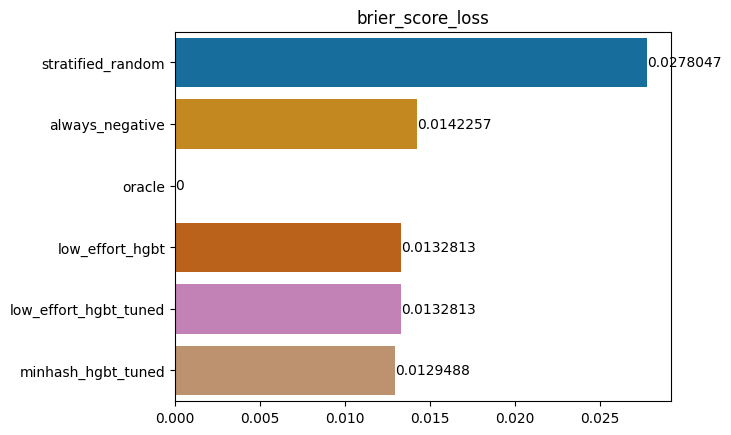

In [29]:
minhash_hgbt_tuned = TunedThresholdClassifierCV(
    minhash_hgbt_search.best_estimator_,
    **tuned_params,
).fit(
    X_trans_val,
    y_val,
    amount=X_val["total_price"],
)

results["minhash_hgbt_tuned"] = get_results(
    minhash_hgbt_tuned,
    X_trans_test,
    y_test,
    amount=X_test["total_price"],
    threshold=minhash_hgbt_tuned.best_threshold_,
)

plot_metric(results, metric_name="brier_score_loss")

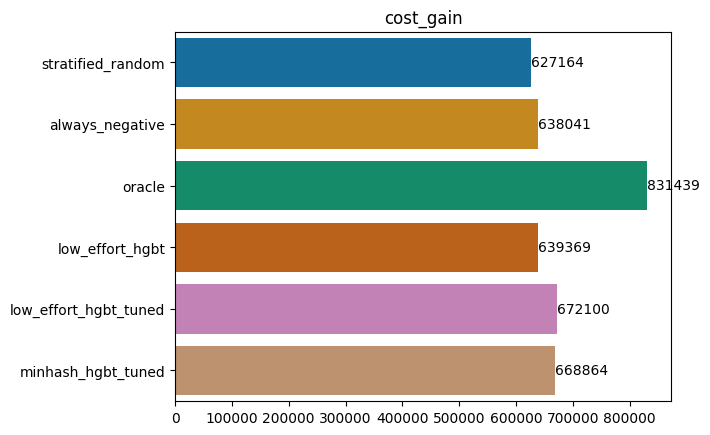

In [30]:
plot_metric(results, metric_name="cost_gain")

The aggregation scheme and minhash encoder improve the brier score, but the gains are very close.

Let's now focus on the most important features for our model, using the `permutation_importance` function from scikit-learn.

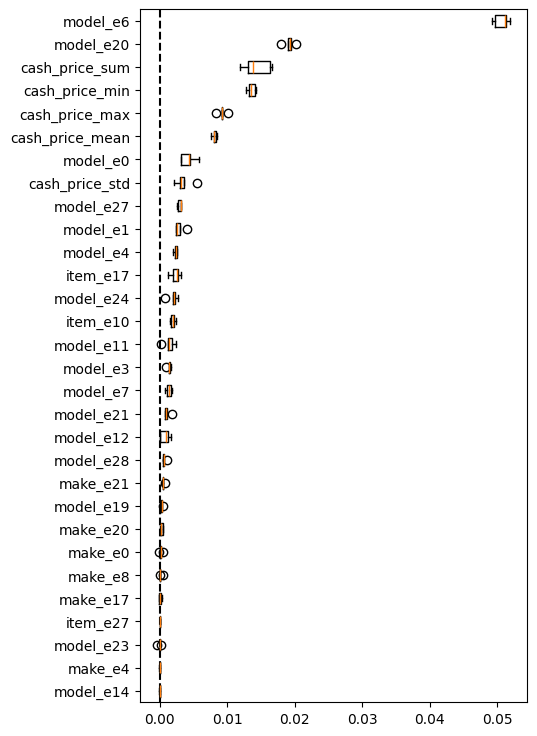

In [31]:
from mandr.examples.fraud.modeling_plots import plot_permutation_importance


n_subsample = 10_000

plot_permutation_importance(
    minhash_hgbt_tuned,
    X_trans_test.head(n_subsample),
    y_test.head(n_subsample),
    random_state=0,
    figsize=(5, 9),
)

Price statistics explain a lot of the target variance for our model, and some embedding dimensions too. MinHash embeddings aren't interpretable however, so we can't deduce which string token from the categories are actually important. This could be done with the GapEncoder.

## 5. NLP estimator

As a next model candidate, we look at semantic embeddings instead of syntaxic embeddings. This means using a naturel language encoder, that has been pretrained on a massive volume of text. The idea is by bringing more powerful embeddings to our final boosting tree estimator, we might see a boost in performance.

We also change our aggregation scheme: instead of computing embedding then aggregating, we first aggregate categorical columns in a single prompt column, and then encode this prompt column using the language model. This will make computation cheaper, and help the encoder to better contextualize its inputs.

The prompt follows the following structure:

> `nbr1` model of `model1` made by `make1` in the category `item1`, and `nbr2` model of `model2` ...

Language models are generally less efficient with numbers, so we convert numbers into text: "1" becomes "one", "2" becomes "two" and so on with the `inflect` library.

In [32]:
import inflect


def make_prompt(X):

    number_converter = inflect.engine()
        
    prompt = pd.Series([""] * X.shape[0], index=X.index, name="prompt")
        
    for idx in range(MAX_ITEMS):
    
        # Add nbr
        nbr_col = get_group_cols("nbr")[idx]
        
        if idx > 0:
            nbr_col = get_group_cols("nbr")[idx]
            mask = X[nbr_col].notnull()
            prompt.loc[mask] += ", and "
    
        X_nbr = X[nbr_col].copy()
        mask = X_nbr.notnull()
        prompt.loc[mask] += (
            X_nbr.loc[mask]
                 .astype(int)
                 .apply(number_converter.number_to_words)
                 .astype(str)
        ) + " model of "
    
        # Add model
        model_col = get_group_cols("model")[idx]
        X_model = X[model_col].copy()
        mask = X_model.notnull()
        prompt.loc[mask] += X_model.loc[mask] + " made by "
    
        # Add make
        make_col = get_group_cols("make")[idx]
        X_make = X[make_col].copy()
        mask = X_make.notnull()
        prompt.loc[mask] += X_make.loc[mask] + " in the category "
    
        # Add item
        item_col = get_group_cols("item")[idx]
        X_item = X[item_col].copy()
        mask = X_make.notnull()
        prompt.loc[mask] += X_item.loc[mask]

    return prompt.to_frame()

Let's observe a few prompts.

In [33]:
make_prompt_transformer = FunctionTransformer(make_prompt)
prompts = make_prompt_transformer.fit_transform(X_train)
sample_prompts = prompts.iloc[9:14].reset_index(drop=True)
sample_prompts.values

array([['one model of SONY BRAVIA XR XR55X90J 2021 LED HDR 4K ULTRA HD S made by SONY in the category TELEVISIONS HOME CINEMA'],
       ['one model of APPLE IPHONE made by APPLE in the category TELEPHONES, FAX MACHINES & TWO-WAY RADIOS, and one model of 2020 APPLE IPAD AIR 10.9" made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE'],
       ['one model of 2022 APPLE IPAD AIR 10 9 M1 PROCESSOR IPADOS WI-FI made by APPLE in the category COMPUTERS'],
       ['one model of 2020 APPLE IPAD AIR 10 9 A14 BIONIC PROCESSOR IOS made by APPLE in the category COMPUTERS'],
       ['one model of ICANDY PEACH DOUBLE PHANTOM PUSHCHAIR DARK GREY TW made by ICANDY in the category BABY CHILD TRAVEL']],
      dtype=object)

Next, we instantiate the encoder from the sentence transformer library, which downloads encoders from HuggingFace. Since we don't fine-tune it, this is a stateless operation.

In [34]:
from sentence_transformers import SentenceTransformer


def sentence_transformer_fn(X, **kwargs):
    original_index = X.index
    X = np.ravel(X)
    model = SentenceTransformer("all-MiniLM-L6-v2")
    X_trans = model.encode(X, **kwargs)
    columns = get_group_cols("e", max_items=X_trans.shape[1])
    return pd.DataFrame(X_trans, columns=columns, index=original_index)

/Users/vincentmaladiere/miniforge3/envs/mandr/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


We then run then sentence transformer on our 5 prompts above, and **observe the cosine similarity of the embeddings**.

The second, third and fourth prompts contains respectively one iPhone and then one iPad each. The first and last prompt contains a Sony tv and a Baby chair. Therefore we expect the Apple product to have a similar embedding, and the rest to be very dissimilar.

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Our embeddings have shape (5, 384)


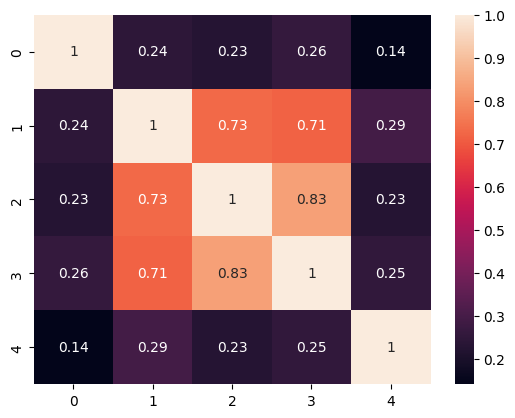

In [35]:
sentence_transformer = FunctionTransformer(
    sentence_transformer_fn, kw_args={"show_progress_bar": True},
)
X_trans = sentence_transformer.fit_transform(sample_prompts)
print(f"Our embeddings have shape {X_trans.shape}")
# Equivalent to # 1 - pairwise_distances(X_trans, metric="cosine")
similarity = X_trans @ X_trans.T
sns.heatmap(similarity, annot=True); 

This is indeed what we observe: the iPad similarities are at 0.83, the iPhone and iPads is 0.73, and the rest is below 0.3.

How does MinHashEncoder embeddings compare? Note that **we have to use hamming distance with the Minhash**.

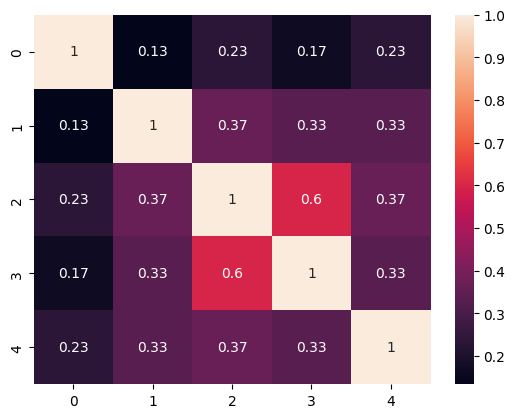

In [36]:
from sklearn.metrics import pairwise_distances

X_trans = MinHashEncoder().fit_transform(sample_prompts["prompt"])
similarity = 1 - pairwise_distances(X_trans, metric="hamming")
sns.heatmap(similarity, annot=True);

The iPads embedding similarity has diminished, and the similarities between unrelated items has increased. Also, MinHash representations for iPhone and iPad are not similar. **So, it seems that our NLP encoder yields better representation than MinHash!**

As the encoder dimensionality is quite high, let's truncate it using a PCA with 128 dimensions. The other transformers are the same as before, and we apply the same randomized search.

In [37]:
from sklearn.decomposition import PCA

nlp_encoder = Pipeline([
    ("make_prompt", make_prompt_transformer),
    ("encoder", sentence_transformer),
    ("pca", PCA(n_components=128)),
])

vectorizer = FeatureUnion([
    ("agg_number", row_aggregate_number_transformer),
    ("nlp_encoder", nlp_encoder),
    ("agg_goods_code", row_aggregate_target_encoder),
]).set_output(transform="pandas")

vectorizer

FeatureUnion(transformer_list=[('agg_number',
                                FunctionTransformer(func=<function row_aggregate_number at 0x29fac6f20>)),
                               ('nlp_encoder',
                                Pipeline(steps=[('make_prompt',
                                                 FunctionTransformer(func=<function make_prompt at 0x29fbf3880>)),
                                                ('encoder',
                                                 FunctionTransformer(func=<function sentence_transformer_fn at 0x15e115440>,
                                                                     kw_args={'show_progress_bar': True})),
                                                ('pca'...
                                                                                   'goods_code11',
                                                                                   'goods_code12',
                                                                                   'goods_code13',
                                                                                   'goods_code14',
                                                                                   'goods_code15',
                                                                                   'goods_code16',
                                                                                   'goods_code17',
                                                                                   'goods_code18',
                                                                                   'goods_code19',
                                                                                   'goods_code20',
                                                                                   'goods_code21',
                                                                                   'goods_code22',
                                                                                   'goods_code23',
                                                                                   'goods_code24'])],
                                                                   verbose_feature_names_out=False)),
                                                ('row_aggregate',
                                                 FunctionTransformer(func=<function row_aggregate_post_target_encoder at 0x29fa6cfe0>))]))])

In [38]:
X_trans_train = vectorizer.fit_transform(X_train, y_train)
X_trans_val = vectorizer.transform(X_val)
X_trans_test = vectorizer.transform(X_test)
X_trans_train

Batches: 100%|████████████████████████████████████████████████████████████████████████| 290/290 [00:17<00:00, 16.27it/s]


,cash_price_mean,cash_price_sum,cash_price_std,cash_price_min,cash_price_max,nbr_mean,nbr_sum,nbr_std,nbr_min,nbr_max,...,pca119,pca120,pca121,pca122,pca123,pca124,pca125,pca126,pca127,goods_code
67930,386.750000,1547.0,451.686008,80.0,1049.0,1.0,4.0,0.0,1.0,1.0,...,0.001735,-0.011001,-0.004186,-0.002104,0.006994,-0.004403,-0.005492,0.000067,0.002922,0.013802
82728,399.000000,399.0,0.000000,399.0,399.0,1.0,1.0,0.0,1.0,1.0,...,0.004414,-0.000007,-0.000078,-0.000999,-0.005186,0.009044,-0.001455,0.000596,-0.000210,0.004148
66599,803.000000,1606.0,1125.713996,7.0,1599.0,1.0,2.0,0.0,1.0,1.0,...,0.043316,0.040686,0.059818,-0.001157,-0.022865,-0.008742,0.015407,-0.027842,-0.009814,0.012469
84151,336.333333,1009.0,530.961706,10.0,949.0,1.0,3.0,0.0,1.0,1.0,...,0.018706,-0.003733,-0.039123,-0.005616,-0.016522,0.001056,-0.077317,0.017565,-0.037022,0.009480
55349,569.000000,569.0,0.000000,569.0,569.0,1.0,1.0,0.0,1.0,1.0,...,-0.002755,-0.011090,0.000706,0.009481,0.014697,0.003451,-0.003628,-0.001748,-0.002618,0.027796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78800,315.333333,946.0,359.808745,75.0,729.0,1.0,3.0,0.0,1.0,1.0,...,0.023219,0.025430,0.013609,-0.074342,0.035139,-0.040044,-0.001630,-0.037093,-0.009541,0.014816
44433,369.000000,369.0,0.000000,369.0,369.0,1.0,1.0,0.0,1.0,1.0,...,-0.007490,-0.002080,0.007504,0.001308,-0.003003,0.002267,0.000125,0.001055,-0.008810,0.000000
58689,269.500000,539.0,381.130555,0.0,539.0,1.0,2.0,0.0,1.0,1.0,...,0.000508,-0.001443,0.004765,-0.010465,-0.001912,0.001082,-0.007461,0.010418,0.001242,0.015023
12559,469.000000,938.0,663.266161,0.0,938.0,1.0,2.0,0.0,1.0,1.0,...,0.002076,0.001163,0.002312,-0.003863,-0.001406,0.000894,0.003487,-0.002735,-0.002992,0.018551


In [39]:
nlp_hgbt = HistGradientBoostingClassifier()

nlp_hgbt_search = RandomizedSearchCV(
    nlp_hgbt,
    **random_search_params,
).fit(X_trans_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


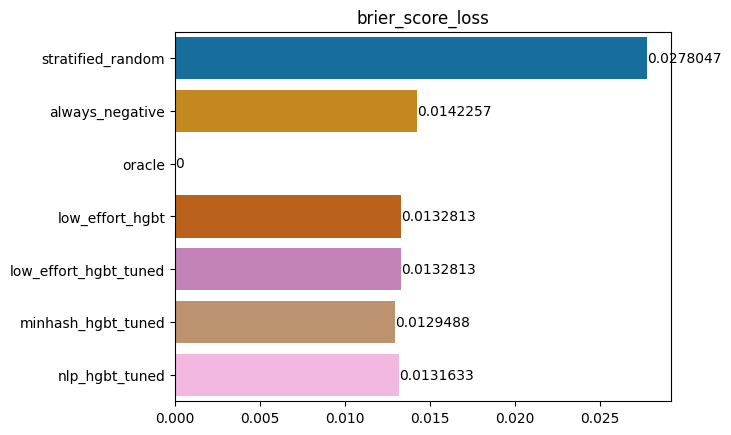

In [40]:
nlp_hgbt_tuned = TunedThresholdClassifierCV(
    nlp_hgbt_search.best_estimator_,
    **tuned_params,
).fit(
    X_trans_val,
    y_val,
    amount=X_val["total_price"],
)

results["nlp_hgbt_tuned"] = get_results(
    nlp_hgbt_tuned,
    X_trans_test,
    y_test,
    amount=X_test["total_price"],
    threshold=nlp_hgbt_tuned.best_threshold_,
)

plot_metric(results, metric_name="brier_score_loss")

The brier score between NLP and Minhash encoders are very close.

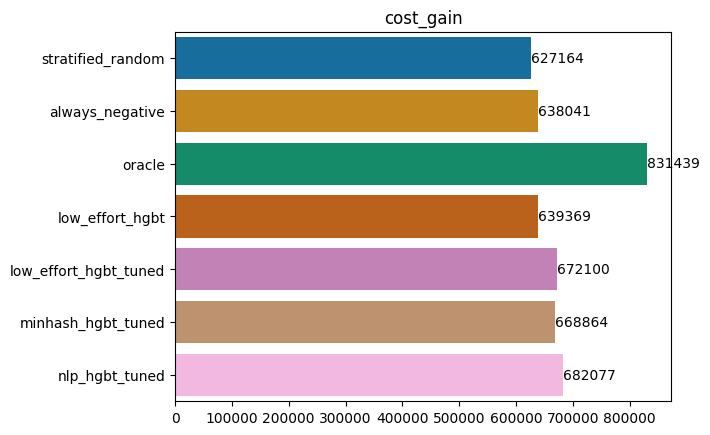

In [41]:
plot_metric(results, metric_name="cost_gain")

The gains are very close too. So, the improvements brought by the NLP encoder is limited, although its embedding are more meaningful than MinHash embeddings.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


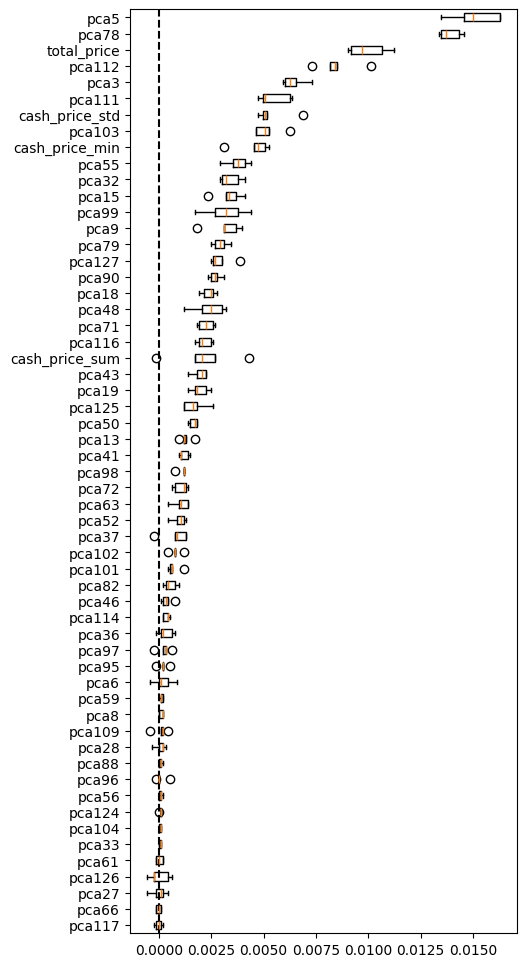

In [42]:
from mandr.examples.fraud.modeling_plots import plot_permutation_importance

n_subsample = 10_000

plot_permutation_importance(
    nlp_hgbt_tuned,
    X_trans_test.head(n_subsample),
    y_test.head(n_subsample),
    figsize=(5, 12),
)

The permutation importances don't bring immediate insight, and we would need to inspect the partial dependencies of different embedding dimensions to get more understanding, before inspecting the prompts of the samples with the highest activations for these embeddings.

## 6. Disagreeing models

We inspect our two last models by first displaying their confusion matrices.

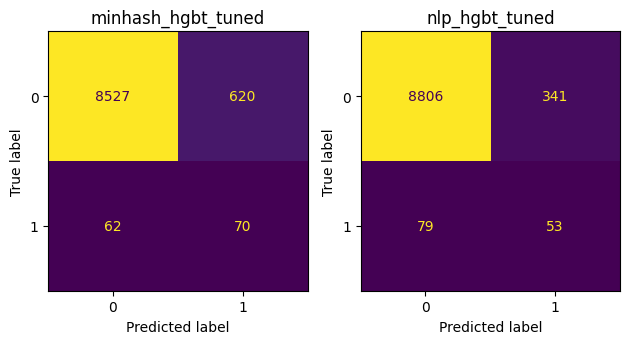

In [43]:
from mandr.examples.fraud.modeling_plots import plot_confusion_matrix

plot_confusion_matrix(
    results,
    model_names=["minhash_hgbt_tuned", "nlp_hgbt_tuned"],
)

Both models have comparable number of false positives.

**Can we compare where these two models disagree?**

In [44]:
def get_disagreeing_between(model_name_1, model_name_2, X_test, y_test, results):
    y_pred_1 = get_y_pred_classes(results, model_name_1)
    y_pred_2 = get_y_pred_classes(results, model_name_2)

    mask = y_pred_1 != y_pred_2

    vectorizer = FeatureUnion([
        ("agg_number", row_aggregate_number_transformer),
        ("nlp_encoder", make_prompt_transformer),
    ]).set_output(transform="pandas")
    prompts = vectorizer.fit_transform(X_test)[["prompt", "cash_price_sum", "nbr_mean"]]
    
    disagreeing_prompts = prompts.loc[mask].copy()
    disagreeing_prompts[model_name_1] = y_pred_1[mask]
    disagreeing_prompts[model_name_2] = y_pred_2[mask]
    disagreeing_prompts["y_test"] = y_test.loc[mask]

    return disagreeing_prompts
    

def get_y_pred_classes(results, model_name):
    y_proba = results[model_name]["y_proba"]
    threshold=results[model_name]["model"].best_threshold_
    return (y_proba[:, 1] > threshold).astype("int32")

We first display the prompts where the nlp model correctly predicts 1 (a fraud), while the minhash predicts 0 (a legit basket). We focus on false negative, since these are the most expensive errors.

In [45]:
disagreeing_prompts = get_disagreeing_between(
    "minhash_hgbt_tuned", "nlp_hgbt_tuned", X_test, y_test, results
)

pd.set_option('display.max_colwidth', 1000)
disagreeing_prompts.query(
    "nlp_hgbt_tuned == 1 & y_test == 1"
)

,prompt,cash_price_sum,nbr_mean,minhash_hgbt_tuned,nlp_hgbt_tuned,y_test
56775,"one model of SONY BRAVIA KD75X89J 2021 LED HDR 4K ULTRA HD SMAR made by SONY in the category TELEVISIONS HOME CINEMA, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",1369.0,1.0,0,1,1
49635,"one model of 2020 APPLE IPAD PRO 12.9"" made by APPLE in the category COMPUTERS",1499.0,1.0,0,1,1
20605,"one model of SAMSUNG QE85Q60A 2021 QLED HDR 4K ULTRA HD SMART T made by SAMSUNG in the category TELEVISIONS HOME CINEMA, and one model of SONOS ARC SMART SOUND BAR WITH DOLBY ATMOS VOICE C made by SONOS in the category TELEVISIONS HOME CINEMA, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",3094.0,1.0,0,1,1


Then, we observe prompts where the minhash model correctly predicts 1 and the nlp model predicts 0.

In [46]:
disagreeing_prompts.query(
    "minhash_hgbt_tuned == 1 & y_test == 1"
)

,prompt,cash_price_sum,nbr_mean,minhash_hgbt_tuned,nlp_hgbt_tuned,y_test
45346,"one model of APPLE IPHONE 12 made by APPLE in the category TELEPHONES, FAX MACHINES & TWO-WAY RADIOS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",781.0,1.0,1,0,1
8144,one model of 2019 APPLE MACBOOK PRO 16 TOUCH BAR INTEL CORE I7 made by APPLE in the category COMPUTERS,2399.0,1.0,1,0,1
47286,one model of 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,1899.0,1.0,1,0,1
73854,one model of 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,1769.0,1.0,1,0,1
52902,"one model of 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 128G made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",760.0,1.0,1,0,1
74525,one model of 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,1899.0,1.0,1,0,1
15794,one model of 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,1899.0,1.0,1,0,1
71586,"one model of 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 256G made by APPLE in the category COMPUTERS, and one model of 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 12 made by APPLE in the category COMPUTERS",1848.0,1.0,1,0,1
78623,one model of 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,1763.0,1.0,1,0,1
68853,one model of 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,2399.0,1.0,1,0,1


The difference of the false negative between these two models is not obvious. Most disagreeing false negative baskets contains Apple products.

Finally, let's observe prompts where both models yield false negative.

In [47]:
def get_agreeing_between(model_name_1, model_name_2, X_test, y_test, results):
    y_pred_1 = get_y_pred_classes(results, model_name_1)
    y_pred_2 = get_y_pred_classes(results, model_name_2)

    mask = y_pred_1 == y_pred_2

    vectorizer = FeatureUnion([
        ("agg_number", row_aggregate_number_transformer),
        ("nlp_encoder", make_prompt_transformer),
    ]).set_output(transform="pandas")
    prompts = vectorizer.fit_transform(X_test)[["prompt", "cash_price_sum", "nbr_mean"]]
    
    agreeing_prompts = prompts.loc[mask].copy()
    agreeing_prompts[model_name_1] = y_pred_1[mask]
    agreeing_prompts[model_name_2] = y_pred_2[mask]
    agreeing_prompts["y_test"] = y_test.loc[mask]

    return agreeing_prompts

In [48]:
agreeing_prompts = get_agreeing_between(
    "minhash_hgbt_tuned", "nlp_hgbt_tuned", X_test, y_test, results
)

agreeing_prompts.query(
    "nlp_hgbt_tuned == 0 & y_test == 1"
).head(30)

,prompt,cash_price_sum,nbr_mean,minhash_hgbt_tuned,nlp_hgbt_tuned,y_test
61300,one model of 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI CE made by APPLE in the category COMPUTERS,2149.0,1.0,0,0,1
53669,"one model of 2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 PROC made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",894.0,1.0,0,0,1
54735,"one model of 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 12 made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",1006.0,1.0,0,0,1
75970,"one model of APPLE IPHONE 12 made by APPLE in the category TELEPHONES, FAX MACHINES & TWO-WAY RADIOS",774.0,1.0,0,0,1
39694,"one model of 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",2432.0,1.0,0,0,1
62416,"one model of 2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESSOR 8 made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",1156.0,1.0,0,0,1
12043,one model of 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 25 made by APPLE in the category COMPUTERS,1099.0,1.0,0,0,1
3137,"one model of 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 128G made by APPLE in the category COMPUTERS, and one model of RETAILER made by RETAILER in the category FULFILMENT CHARGE",756.0,1.0,0,0,1
46840,one model of 2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESSOR 8 made by APPLE in the category COMPUTERS,1149.0,1.0,0,0,1
90677,one model of 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA made by APPLE in the category COMPUTERS,2599.0,1.0,0,0,1


Interestingly, both models fail at detecting fraudulent basket containing a single Apple product. Maybe these baskets don't exhibit any difference with non fraudulent ones?

## 7. Conclusion

We have compared three models against baselines, and seen a difference between our low effort against the Minhash aggregation, however NLP embeddings didn't show tangible improvement over the MinHash ones.

This is understandable as the prompts were made over short textual categories with morphological differences with very little context available, a favourable context for a computationally cheap encoder like MinHash.

We conclude this example with ROC curves, PR curves and the calibration curves of our models.

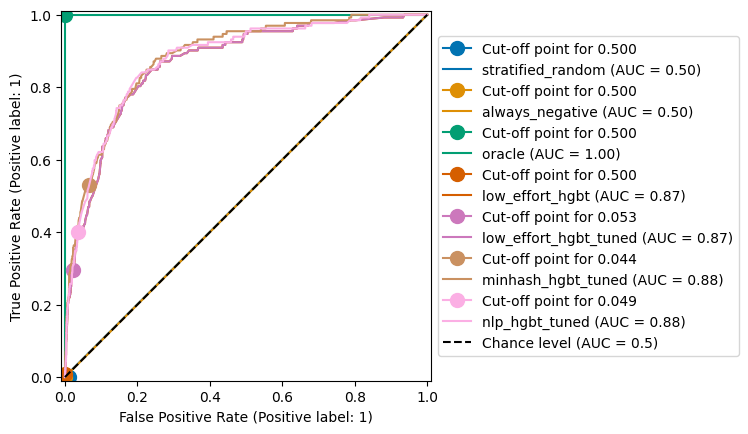

In [49]:
from mandr.examples.fraud.modeling_plots import plot_roc_curve

plot_roc_curve(results)

Minhash has the best ROC AUC.

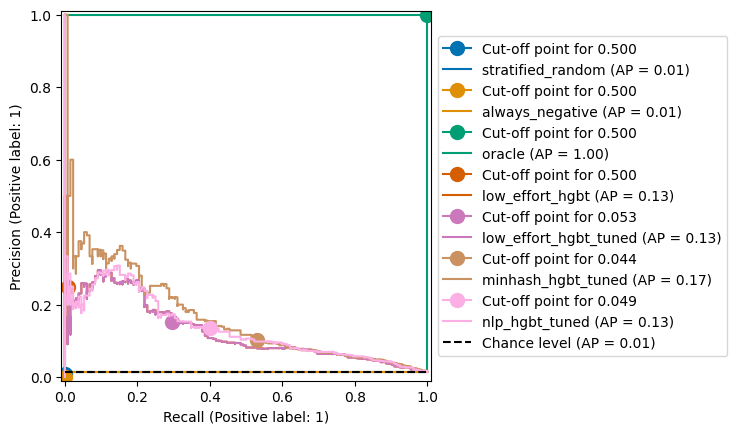

In [50]:
from mandr.examples.fraud.modeling_plots import plot_pr_curve

plot_pr_curve(results)

MinHash has the best average precision (PR AUC), which is the initial metric of the challenge.

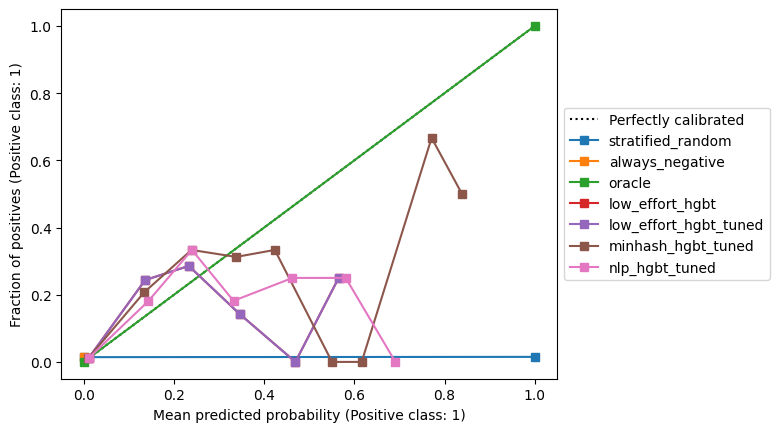

In [51]:
from mandr.examples.fraud.modeling_plots import plot_calibration_curve

plot_calibration_curve(results)

All calibration curves are extremely bad past the 40% predicted probability bin. The NLP encoder is slightly more calibrated than MinHash at the beginning, but MinHash final bin at 80% is close to the correct calibration. This disparity is due to the very low prevalence of the target: there is almost no prediction beyond 40%.

If we wanted to use these predicted scores as confidence estimate, a good first step would be to calibrate our models using a Isotonic Regressor. This would reduce the calibration error **in average**, but wouldn't eliminate the **grouping loss**, i.e. the variance in calibration error within each bins, which would need to be examined separately.

## 8. To go beyond

There are different directions we can think of to improve our modeling:

- Adding confidence intervals on our metrics by using an outer cross validation on the initial train, val and test splitting operation, via multiple random states.
- Stacking a kNearestNeighbors transformer to aggregate the target, total_prices and numeric columns, after vectorizing the categorical entities.
- More expensive hyper-parameters tuning, in particular for the vectorizers output dimensions.
- Ensembling estimator with different inductive biases (kNN classifiers, linear models)
- Using a graph neural network classifier like CARTE, to jointly encode numeric and categorical features representations.